# Clasificador de texto con CNN
Implementemos un clasificador con Convolutional Neural Networks aplicado al análisis de sentimiento en Twitter usando la librería `Keras`.  
Aplicamos una primera capa de embeddings para convertir las palabras en vectores y luego entrenamos con una red CNN (seleccionando el max-pooling de cada filtro para obtener un vector por tweet).  
Para calcular los embeddings usamos:  
- Una capa de embeddings propia sobre los tweets
- Transfer Learning con los word embeddings de spaCy 
- Transfer Learning con los word embeddings de GloVe 

Implementado según el modelo planteado en [Convolutional Neural Networks for Sentence Classification](http://arxiv.org/abs/1408.5882)

In [1]:
import pandas as pd
import numpy as np
import re, string, spacy
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Activation, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = None
np.random.seed(123)

2024-08-12 13:13:12.934318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Leemos los datos
df = pd.read_csv('tweets_max.csv', index_col=None)

#seleccionamos columnas de interés
df = df[['content', 'polarity']]

#dejamos polaridades definidas
df = df[(df['polarity']=='P') | (df['polarity']=='N')]

df.head()

,content,polarity
0,"@myendlesshazza a. que puto mal escribo b. me sigo surrando help 3. ha quedado raro el ""cómetelo"" ahí JAJAJAJA",N
1,Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps,P
2,Vale he visto la tia bebiendose su regla y me hs dado muchs grima,N
3,@Yulian_Poe @guillermoterry1 Ah. mucho más por supuesto! solo que lo incluyo. Me habías entendido mal,P
4,@toNi_end seria mejor que dejasen de emitir esa basura ya hay que evolucionar para bien y eso,N


In [3]:
df.polarity.value_counts()

polarity
N    840
P    609
Name: count, dtype: int64

## Limpieza de texto
Usamos Spacy para separar el texto en tokens y mantener sólo las palabras importantes, dejando su lema (opcional) en minúsculas

In [4]:
import re, string, spacy
nlp=spacy.load('es_core_news_md')

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text) #elimina menciones y URL
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens] #no quitamos stop-words
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text
    

## Preparamos el conjunto de datos
Convertimos el texto en *tokens* y asignamos una ID numérica a cada token.  
Convertimos a secuencias de longitud fija.  
La longitud de la secuencia viene dada por la longitud en tokens del tweet más largo. Sólo se conservan los tokens de las palabras en el vocabulario.

In [5]:
#limpiamos texto y quitamos tweets que se han quedado vacíos
df.content=df.content.apply(clean_text, lemas=True)
df = df[df['content']!='']

#el conjunto de salida es la polaridad, hay que convertir a numérico para Keras
#codificamos 'P' como 1 y 'N' se queda como 0
Y=(df.polarity=='P').values*1

#Separamos entrenamiento y test
tweets_train, tweets_test, Y_train, Y_test = train_test_split(df.content,Y,
    test_size = 0.3,
    random_state = 0)

In [6]:
len(tweets_train)

1014

In [7]:
tweets_train.head(5)

884                                                                                                salir   para zaragoza   fin de semana único
1866                                                joder pobre hombre estar oprimido por mujer que él obligar a afeitar él \n justice4hombres
563                                                                        no a el agresión sexista durante y después de el fiestas   sangüesa
1547                                          callar que yo estar ahora en mi día libre y el hora él pasar más rápido que poner copa en el bar
915     desde que haber volver a mi casa él llevar todo bien porque cada vez que pasar algo yo echar el culpa a yo y él quedar tanto tranquilo
Name: content, dtype: object

In [8]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(tweets_train.values)
X_train = tokenizer.texts_to_sequences(tweets_train.values)
X_train = pad_sequences(X_train, padding='post')
word_index = tokenizer.word_index
print(f'Número de tokens distintos: {len(word_index)}')
MAX_SEQUENCE_LENGTH = X_train.shape[1]
max_features = len(word_index)+1
X_test = tokenizer.texts_to_sequences(tweets_test.values)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

Número de tokens distintos: 3220


In [9]:
X_train.shape

(1014, 33)

In [10]:
X_train[0]

array([  72,   25, 1068,  168,    3,  132,  142,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [11]:
tweets_train.values[0]

'salir   para zaragoza   fin de semana único'

In [12]:
tokenizer.document_count

1014

In [13]:
tokenizer.index_word[130]

'mundo'

In [14]:
tokenizer.word_index['claro']

165

In [15]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1014, 33) (1014,)
(435, 33) (435,)


## Word embeddins propios
Entrenamos una capa de embedding para aprender los WE con los textos de nuestro problema.

In [16]:
#Creamos el modelo CNN en Keras
#Usamos como referencia el ejemplo de Keras: https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py
#pero quitamos la capa oculta intermedia para simplificar el modelo y dejarlo como en el artículo

#Parámetros de la red
embed_dim = 50
filters = 64
kernel_size = 3

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.2))

# añadimos una capa de convolución 1D que aprende
# filtros de grupos de palabras de tamaño kernel_size
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# calculamos el max pooling:
model.add(GlobalMaxPooling1D())

# conectamos a una capa de salida de una unidad con activación sigmoide
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compilamos el modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 50)            161050    
                                                                 
 dropout (Dropout)           (None, 33, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 31, 64)            9664      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                        

### Pregunta:
¿de dónde vienen los tamaños de los parámetros de cada capa?

In [20]:
print(f'Embedding: {max_features*embed_dim}')
print(f'Embedding: {filters*kernel_size*embed_dim} + 64 (bias)')
print(f'Dense: {filters} + 1 (bias)')


Embedding: 161050
Embedding: 9600 + 64 (bias)
Dense: 64 + 1 (bias)


#solución



In [21]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/20
64/64 - 2s - loss: 0.6795 - accuracy: 0.5730 - val_loss: 0.6615 - val_accuracy: 0.5954 - 2s/epoch - 30ms/step
Epoch 2/20
64/64 - 0s - loss: 0.6452 - accuracy: 0.5927 - val_loss: 0.6235 - val_accuracy: 0.6345 - 445ms/epoch - 7ms/step
Epoch 3/20
64/64 - 1s - loss: 0.5781 - accuracy: 0.7702 - val_loss: 0.5823 - val_accuracy: 0.7448 - 503ms/epoch - 8ms/step
Epoch 4/20
64/64 - 0s - loss: 0.4512 - accuracy: 0.8708 - val_loss: 0.5302 - val_accuracy: 0.7264 - 458ms/epoch - 7ms/step
Epoch 5/20
64/64 - 1s - loss: 0.2806 - accuracy: 0.9191 - val_loss: 0.5216 - val_accuracy: 0.7471 - 506ms/epoch - 8ms/step
Epoch 6/20
64/64 - 0s - loss: 0.1524 - accuracy: 0.9744 - val_loss: 0.5888 - val_accuracy: 0.7218 - 433ms/epoch - 7ms/step
Epoch 7/20
64/64 - 1s - loss: 0.0789 - accuracy: 0.9911 - val_loss: 0.6459 - val_accuracy: 0.7264 - 683ms/epoch - 11ms/step
Epoch 8/20
64/64 - 1s - loss: 0.0405 - accuracy: 0.9951 - val_loss: 0.6765 - val_accuracy: 0.7471 - 614ms/epoch - 10ms/step
Epoch 9/20
64/64

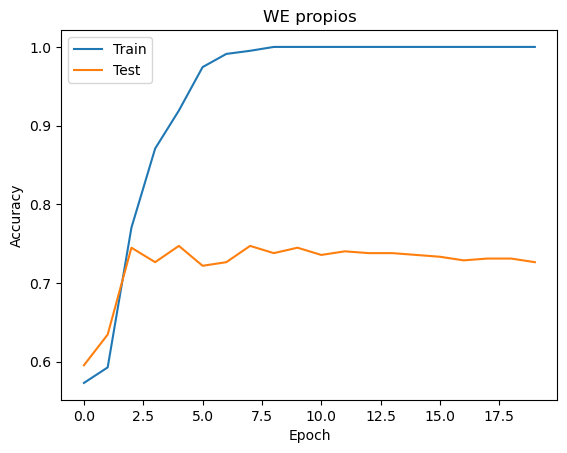

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('WE propios')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
#los word embeddings aprendidos son los pesos de la primera capa
embeddings=model.get_weights()[0]

In [24]:
embeddings.shape

(3221, 50)

In [25]:
tokenizer.index_word[15]

'pero'

In [26]:
embeddings[15]

array([-0.01301138, -0.00908576,  0.00078868, -0.02144798, -0.02604739,
       -0.02860799, -0.02913709,  0.0341679 ,  0.04044621,  0.00381141,
        0.03467025, -0.04894548,  0.00342609,  0.08879347,  0.09360139,
        0.04258834,  0.02404998,  0.00775098,  0.07161411, -0.10004772,
       -0.02048737, -0.069721  , -0.11125509, -0.01388593, -0.01602354,
       -0.01894629, -0.14559394,  0.07290064, -0.04107955,  0.08717999,
       -0.00121627,  0.06113689,  0.04793368,  0.08316692,  0.02464296,
        0.04007035,  0.03175807, -0.06846772,  0.03649272, -0.04532928,
        0.10285844, -0.02075255, -0.10989614,  0.07148091,  0.05220297,
       -0.0364974 , -0.04047771, -0.05142573, -0.02318121,  0.04427943],
      dtype=float32)

In [27]:
word_index['querer']

40

In [28]:
word_index['fácil']

420

In [29]:
word_index['morir']

317

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([embeddings[word_index['querer']], embeddings[word_index['fácil']], embeddings[word_index['morir']]])

array([[ 0.9999999 ,  0.158616  , -0.14041814],
       [ 0.158616  ,  0.99999994,  0.28517097],
       [-0.14041814,  0.28517097,  0.99999994]], dtype=float32)

In [31]:
cosine_similarity([nlp.vocab['querer'].vector, nlp.vocab['fácil'].vector, nlp.vocab['morir'].vector])

array([[ 0.99999976,  0.44533116,  0.34367532],
       [ 0.44533116,  1.        , -0.04046382],
       [ 0.34367532, -0.04046382,  1.        ]], dtype=float32)

In [32]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

28/28 - 0s - loss: 1.0081 - accuracy: 0.7264 - 86ms/epoch - 3ms/step
score: 1.01
acc: 0.73


In [33]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

435/435 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           N       0.83      0.68      0.75       259
           P       0.63      0.79      0.70       176

    accuracy                           0.73       435
   macro avg       0.73      0.74      0.72       435
weighted avg       0.75      0.73      0.73       435



## Word embeddings de spaCy
Aplicamos Transfer Learning usando los embeddings GloVe incluidos en el modelo de spaCy.

In [34]:
nlp=spacy.load('es_core_news_md')
#Rellenamos los vectores con el valor en spaCy para nuestro vocabulario
EMBEDDING_DIM = nlp.vocab.vectors_length
embedding_matrix = np.random.rand(max_features, EMBEDDING_DIM)-0.5
#embedding_matrix = np.zeros((max_features, EMBEDDING_DIM))
n = 0
for word, i in word_index.items():
    if(i>max_features):
        break
    if nlp.vocab[word].has_vector:
        # las palabras que no están en spaCy serán cero.
        embedding_matrix[i] = nlp.vocab[word].vector
        n = n + 1
print(f"Cargados {n} vectores en la matriz")

Cargados 2790 vectores en la matriz


In [35]:
embedding_matrix.shape

(3221, 300)

In [36]:
#Creamos el modelo CNN en Keras

#parámetros de la red
filters = 64
kernel_size = 3

embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 300)           966300    
                                                                 
 dropout_1 (Dropout)         (None, 33, 300)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 64)            57664     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,024,029
Trainable params: 1,024,029
Non-trainable params: 0
____________________________________________

In [37]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/20
64/64 - 4s - loss: 1.8089 - accuracy: 0.5740 - val_loss: 1.3545 - val_accuracy: 0.6897 - 4s/epoch - 63ms/step
Epoch 2/20
64/64 - 1s - loss: 1.1500 - accuracy: 0.7002 - val_loss: 1.0171 - val_accuracy: 0.6713 - 1s/epoch - 20ms/step
Epoch 3/20
64/64 - 1s - loss: 0.7013 - accuracy: 0.7890 - val_loss: 1.0348 - val_accuracy: 0.6943 - 1s/epoch - 21ms/step
Epoch 4/20
64/64 - 1s - loss: 0.4974 - accuracy: 0.8284 - val_loss: 1.2277 - val_accuracy: 0.6966 - 1s/epoch - 21ms/step
Epoch 5/20
64/64 - 2s - loss: 0.5301 - accuracy: 0.8304 - val_loss: 1.0263 - val_accuracy: 0.7195 - 2s/epoch - 25ms/step
Epoch 6/20
64/64 - 1s - loss: 0.3885 - accuracy: 0.8698 - val_loss: 1.1946 - val_accuracy: 0.7172 - 1s/epoch - 21ms/step
Epoch 7/20
64/64 - 1s - loss: 0.4266 - accuracy: 0.8609 - val_loss: 1.2958 - val_accuracy: 0.6598 - 1s/epoch - 22ms/step
Epoch 8/20
64/64 - 1s - loss: 0.3014 - accuracy: 0.8905 - val_loss: 1.1162 - val_accuracy: 0.7126 - 1s/epoch - 21ms/step
Epoch 9/20
64/64 - 1s - loss: 0.

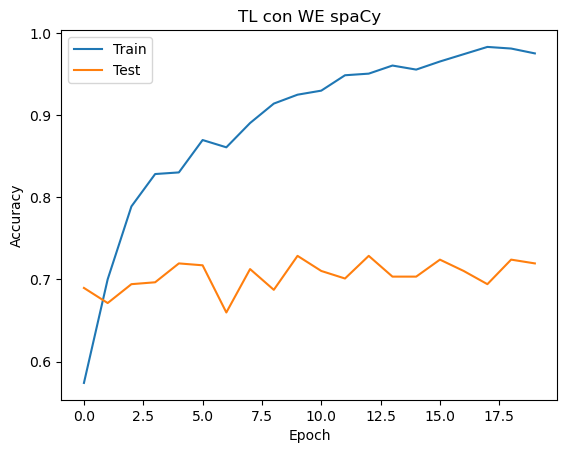

In [38]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('TL con WE spaCy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

28/28 - 0s - loss: 1.2142 - accuracy: 0.7195 - 132ms/epoch - 5ms/step
score: 1.21
acc: 0.72


In [40]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

435/435 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           N       0.74      0.81      0.77       259
           P       0.68      0.59      0.63       176

    accuracy                           0.72       435
   macro avg       0.71      0.70      0.70       435
weighted avg       0.72      0.72      0.72       435



### Word embeddings de FastText
Podemos usar cualquier conjunto de *word embeddings* con el formato `KeyedVectors` de Gensim para hacer Transfer Learning.  
WE descargados desde https://fasttext.cc/docs/en/crawl-vectors.html

In [43]:
from gensim.models.keyedvectors import KeyedVectors
#https://github.com/mquezada/starsconf2018-word-embeddings
modelWE = KeyedVectors.load_word2vec_format('../../1_Funtamentos/Notebooks_P3/fasttext-sbwc.100k.vec')

EMBEDDING_DIM = modelWE.vector_size

#embedding_matrix = np.zeros((max_features, EMBEDDING_DIM))
embedding_matrix = np.random.rand(max_features, EMBEDDING_DIM)-0.5

vectores = 0
for word, i in word_index.items():
    if(i<max_features):
        try:
            embedding_vector = modelWE[word]
            vectores += 1
        except:
            embedding_vector = np.zeros(EMBEDDING_DIM)
            # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print(f"Cargados {vectores} vectores en la matriz")

Cargados 2420 vectores en la matriz


In [44]:
embedding_matrix.shape

(3221, 300)

In [45]:
cosine_similarity([modelWE['querer'], modelWE['fácil'], modelWE['morir']])

array([[1.0000001 , 0.42363524, 0.44136155],
       [0.42363524, 1.        , 0.22116598],
       [0.44136155, 0.22116598, 0.99999976]], dtype=float32)

In [46]:
#Creamos el modelo CNN en Keras

#parámetros de la red
filters = 64
kernel_size = 3

embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 33, 300)           966300    
                                                                 
 dropout_2 (Dropout)         (None, 33, 300)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 31, 64)            57664     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,024,029
Trainable params: 1,024,029
Non-trainable params: 0
____________________________________________

In [47]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/20
64/64 - 2s - loss: 0.6858 - accuracy: 0.5720 - val_loss: 0.5905 - val_accuracy: 0.7425 - 2s/epoch - 32ms/step
Epoch 2/20
64/64 - 1s - loss: 0.5032 - accuracy: 0.8037 - val_loss: 0.5326 - val_accuracy: 0.7563 - 1s/epoch - 20ms/step
Epoch 3/20
64/64 - 1s - loss: 0.3651 - accuracy: 0.8925 - val_loss: 0.4759 - val_accuracy: 0.7701 - 1s/epoch - 20ms/step
Epoch 4/20
64/64 - 1s - loss: 0.2465 - accuracy: 0.9329 - val_loss: 0.4648 - val_accuracy: 0.7839 - 1s/epoch - 19ms/step
Epoch 5/20
64/64 - 1s - loss: 0.1519 - accuracy: 0.9773 - val_loss: 0.4678 - val_accuracy: 0.7931 - 1s/epoch - 19ms/step
Epoch 6/20
64/64 - 1s - loss: 0.0979 - accuracy: 0.9872 - val_loss: 0.4901 - val_accuracy: 0.7793 - 1s/epoch - 17ms/step
Epoch 7/20
64/64 - 1s - loss: 0.0562 - accuracy: 0.9961 - val_loss: 0.5157 - val_accuracy: 0.7793 - 1s/epoch - 19ms/step
Epoch 8/20
64/64 - 1s - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.5450 - val_accuracy: 0.7724 - 1s/epoch - 20ms/step
Epoch 9/20
64/64 - 1s - loss: 0.

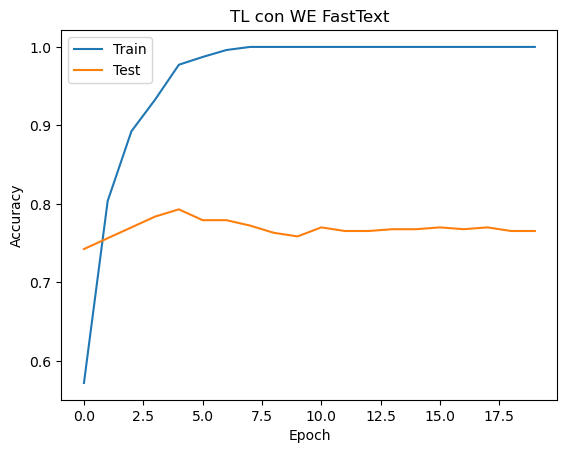

In [48]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('TL con WE FastText')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [49]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

28/28 - 0s - loss: 0.7652 - accuracy: 0.7655 - 115ms/epoch - 4ms/step
score: 0.77
acc: 0.77


In [50]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=['N','P']))

435/435 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           N       0.80      0.80      0.80       259
           P       0.71      0.71      0.71       176

    accuracy                           0.77       435
   macro avg       0.76      0.76      0.76       435
weighted avg       0.77      0.77      0.77       435



### Inferencia en nuevos textos

Si queremos utilizar el clasificador con un texto nuevo hay que procesar el texto con la misma secuencia: limpieza, tokenizado y conversión en secuencia de la longitud adecuada:

In [51]:
twt = 'me quiero morir'
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences([clean_text(twt, lemas=True)]) #hay que pasar el texto a array
#padding the tweet to have exactly the same shape as `embedding_2` input

In [52]:
twt

[[4, 40, 317]]

In [53]:
twt = pad_sequences(twt, maxlen=X_train.shape[1], dtype='int32', padding='post', truncating='post', value=0)
twt

array([[  4,  40, 317,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [54]:
sentiment = model.predict(twt,batch_size=1,verbose = 2)
if(np.round(sentiment) == 0):
    print("negativo")
elif (np.round(sentiment) == 1):
    print("positivo")

1/1 - 0s - 17ms/epoch - 17ms/step
negativo


In [55]:
sentiment

array([[0.00121737]], dtype=float32)